In [487]:
import pandas as pd
import sklearn as sns
import math
import random
from operator import itemgetter
import random
import numpy as np

# Prepare Data and split dataset into train and test

In [488]:
movie = pd.read_csv("./dataset/ratings.csv")
movie = movie.drop(columns = ['timestamp'])
# movie = movie.drop(columns = ['timestamp'])[["userId","movieId"]]
# movie[["userId","movieId"]]
movie.head()
# # print(movie.index)
# table = pd.pivot_table(movie,values = "rating",index = ['userId'],columns = ['movieId'])
# # list(table.index)
# table.head()
# print(list(movie.items()))
# for u,i in movie.items():
#     print([u,i])

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [457]:
# #prepare the input data for calculating similarity
# def DataPrep1(raw_data):
#     Data = {}
#     for index,row in raw_data.iterrows():
#         if row['movieId'] not in Data:
#             Data[row['movieId']] = {}
# #         if(row['rating']>=0):
#         Data[row['movieId']][row['userId']] = row['rating']
#     return Data

In [458]:
#prepare the input data for training model
def DataPrep2(raw_data):
    Data = {}
    for index,row in raw_data.iterrows():
        if row['userId'] not in Data:
            Data[row['userId']] = {}
#         if(row['rating']>=0):
        Data[row['userId']][row['movieId']] = row['rating']
    return Data

In [459]:
#split the dataset into train and test
#the latter for the purpose of evaluation by using rmse
def datasplit(data,seed,m,k):
    train_set = {}
    y_set = {}
    random.seed(seed)
    for user in data:
        y_set[user] = {}
        train_set[user] = {}
        for movie in data[user]:
            if random.randint(0,m)<k:
                y_set[user][movie] = data[user][movie]
            else:
                train_set[user][movie] = data[user][movie]
#         train = movies[:int(0.8*len(movies))]
#         y = movies[int(0.8*len(movies)):]
    #print('Data preparation finished')
    return train_set, y_set

In [460]:
feed_data = DataPrep2(movie)
train, test = datasplit(feed_data,2,10,2.5)
print(len(train[1]),len(test[1]))

163 69


In [475]:
#transfer the format of train dataset for computing similarity
def get_sim_feed_data(train):
    train_sim = {}
    for user in train:
        for movie in train[user]:
            if movie not in train_sim:
                train_sim[movie] = {}
            train_sim[movie][user] = train[user][movie]
    return train_sim

In [477]:
train_sim = get_sim_feed_data(train)

# Calculate the similarity of two movies

% Insight of the similarity algorithm:

- This step is the most critical move in the whole item based model
- The basic idea of this algothrim is 

    - First, by only looking into the co-rated movies, we build a set of users who have watched this movie i and then we construct the co-ocurrence matrix of movies, each its cell records the number of users who like both movie i and movie j.
    
    - We compute the similarity of two movies in the terms of describing their cosine distance.
    $sim(i,j) = \frac{\sum_{u\in U}(R_{u,i}-\overline{R})(R_{u,j}-\overline{R})}{\sqrt{\sum_{u\in U}(R_{u,i}-\overline{R})^2}\sqrt{\sum_{u\in U}(R_{u,j}-\overline{R})^2}}$, where $\overline{R}$ is the average of $u$-th user's rating scores.
    
    - To give a predicting score to an unwatched by user $u$, we use weighted sum method, details as below:
        - For a given user $u$, we calculate look into each movie in the movie set that this user has not watched, and sum up the contributions made from all the movie set that this user has watched by multiplying the similarity weight and the ratings rated by the user. 
    
    - However, this method has a fatal problem, when the movie is a very popular one, then the number of users who like it will be large, which means that the denominator in the formula will be big, and then its weight will be heavy, but the fact may be not the case. Then when using weighted sum method to predict the rating of a unwatched movie will be not convincing.
    
    - To tackle this problem, we normalize the weight by dividing by its maximal weight. 

In [463]:
def CompMatrix(data_sim):
    C = {}
    N = {}
    for i,users1 in data_sim.items():
        for u1 in users1:
            if i not in N:
                N[i] = 1
            else:
                N[i] += 1
            for j,users2 in data_sim.items():
    #         print(users,items)
                if i == j:
                    continue
                #u1 has interests in both item1 and item2
                if u1 in users2:
#                     corating = -abs(data_sim[i][u1]-data_sim[j][u1])+5
                    if i not in C:
                        C[i] = {j:1}
                    else:
                        if j not in C[i]:
                            C[i][j] = 1
                        else:
                            C[i][j] += 1
    return C,N

In [464]:
C,N = CompMatrix(train_sim)

In [466]:
def CalItemSimilarity(C,N):
    W = {}
    for i, related_items in C.items():
#         max_w = max(related_items.items(), key=itemgetter(1))[0]
        for j,Cij in related_items.items():
            temp = Cij/math.sqrt(N[i]*N[j])
            if i not in W:
                W[i] = {j:temp}
            if j not in W[i]:
                W[i][j] = temp
    return W

In [467]:
Weight = CalItemSimilarity(C,N)

In [468]:
def Recommendation(train,user_id,W,k):
    rank = {}
    ru = train[user_id] #get the set of movies watched by user_id
    #the original idea in the recommand system book is a bit unreasonable in logic
    #the way they do it is:
    #loop through the watched movie set, say current loop is in watched movie i
        #and then take the top k unwacthed movie in similarity with the movie i
        #sum up the weighted rating got from all watched movies i based on similarity of the unwatched movie j
    #here comes a problem, say watched movie i_1 has the set of unwatched movie: j_1,j_2,j_3
    #and watched movie i_2 has the set of unwatched movie: j_1,j_2,j_4
    #then, when sum then up, the unwatched movies j_3 and j_4 will receive unfair treatment 
    #by only having one contribution compared with j_1 and j_2
    #implementation in their unfair idea
#     for i in ru:
#         #iterate all movies j that user_id havent watched yet
#         for j,wij in sorted(W[i].items(),key = itemgetter(1),reverse = True)[0:k]:
#             if j in ru:
#                 continue
#             #get the rating of movie i rated by user_id
#             pi = ru[i]
#             if j in rank:
#                 rank[j] += pi*wij
#             else:
#                 rank[j] = pi*wij
    candi = {}
    for j,wd in W.items():
        if j not in ru:
            #get all similarities of j and movies in ru
            for i in ru:
                #if watched movie i is not wij, then movie j and i has no similarity, skip
                #otherwise, append to candi
                if i in wd:
                    if j not in candi:
                        candi[j] = {}
                    if i not in candi[j]:
                        candi[j][i] = 0
                    candi[j][i] = wd[i]
                else: 
                    continue
    for j in candi:
        sum_size = min(k,len(candi[j]))
        sum_w = 0
        sorted_list = sorted(candi[j].items(),key = itemgetter(1),reverse = True)
        maximal_w = sorted_list[0][1]
        for i,w in sorted_list:
            sum_w += w/maximal_w
            pi = ru[i]
            if j not in rank:
                rank[j] = 0
            rank[j] += pi*w/maximal_w
            sum_size -= 1
            if sum_size <=0:
                break;
        rank[j] = rank[j]/sum_w
    return rank

In [469]:
#evaluation:
def rmse(pred,real):
    return np.sqrt(np.mean((pred-real)**2))

# Experiment on a given target user

In [544]:
rank = sorted(Recommendation(train,2,Weight,10).items(),key = itemgetter(1),reverse = True)

In [545]:
prediction = pd.DataFrame(rank, columns=['movieId', "pred"])
y = pd.DataFrame(sorted(test[1].items()), columns=['movieId', "rating"])
merge = pd.merge(prediction,y)
merge.head()

,movieId,pred,rating
0,1777.0,4.421946,4.0
1,2096.0,4.293367,4.0
2,2654.0,4.252485,5.0
3,736.0,4.241732,3.0
4,2143.0,4.208355,4.0


In [546]:
rmse(merge["pred"],merge["rating"])

0.9075441268492687

In [547]:
details = pd.read_csv("./dataset/movies.csv")
details.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [549]:
#get recommand movies list of a target user
prediction = pd.DataFrame(rank, columns=['movieId', "pred"])
merge1 = pd.merge(prediction,details)
merge = merge1.drop(columns = ["genres"])
recommended_genres = pd.DataFrame(merge1["genres"])
recommended_genres[["genres","type"]] = recommended_genres["genres"].str.split("|",1, expand = True)
columns = ["movieId","title","pred"]
recommend = merge.reindex(columns=columns).sort_values("pred",ascending=False).reset_index(drop=True)
print("The top 10 recommended movies for user 2:")
recommend.head(10)

The top 10 recommended movies for user 2:


,movieId,title,pred
0,160718.0,Piper (2016),5.000000
1,44889.0,Reefer Madness: The Movie Musical (2005),4.850305
2,58492.0,Snow Angels (2007),4.850305
3,8796.0,"Funny Thing Happened on the Way to the Forum, ...",4.850305
4,34164.0,Happy Endings (2005),4.850305
5,7122.0,King of Hearts (1966),4.850305
6,1734.0,My Life in Pink (Ma vie en rose) (1997),4.638776
7,33880.0,Me and You and Everyone We Know (2005),4.638776
8,91483.0,Bullet to the Head (2012),4.505340
9,95949.0,"Immature, The (Immaturi) (2011)",4.505340


In [485]:
#get the genres of movies recommended to this user
recommended_genres = recommended_genres.drop(columns = "type")
recommended_genres = recommended_genres.groupby(["genres"]).size().reset_index(name='counts')
recommended_genres = recommended_genres.sort_values("counts",ascending=False).reset_index(drop=True)
print("The genres of movies recommended to this user")
recommended_genres.head(10)

The genres of movies recommended to this user


,genres,counts
0,Comedy,2433
1,Drama,1918
2,Action,1602
3,Adventure,575
4,Crime,471
5,Horror,396
6,Documentary,307
7,Animation,239
8,Children,181
9,Thriller,67


In [489]:
#get the genres of movies this user has rated
rated_movieid = movie[movie["userId"] == 1].drop(columns = ["userId","rating"])
merge_movieid = pd.merge(rated_movieid,details)
rated_movie_genres = pd.DataFrame(merge_movieid["genres"])
rated_movie_genres[["genres","type"]] = rated_movie_genres["genres"].str.split("|",1, expand = True)
rated_movie_genres = rated_movie_genres.drop(columns = "type")
rated_movie_genres = rated_movie_genres.groupby(["genres"]).size().reset_index(name='counts')
rated_movie_genres = rated_movie_genres.sort_values("counts",ascending=False).reset_index(drop=True)
print("The genres of movies this user has rated")
rated_movie_genres.head(10)

The genres of movies this user has rated


,genres,counts
0,Action,90
1,Comedy,48
2,Adventure,39
3,Drama,17
4,Crime,15
5,Animation,12
6,Horror,7
7,Children,2
8,Mystery,1
9,Thriller,1


# Experiment on all users to calculate the average rmse

In [540]:
#predict for all users
def averageScore(train,test,Recommendation,*args,**kwargs):
    rmselist = []
    for user in train:
        rank = sorted(Recommendation(train,user,*args,**kwargs).items())
        prediction = pd.DataFrame(rank, columns=['movieId', "pred"])
        y = pd.DataFrame(sorted(test[user].items()), columns=['movieId', "rating"])
        merge = pd.merge(prediction,y)
        error = rmse(merge["pred"],merge["rating"])
        if error > 0:
            rmselist.append(error)
    return np.mean(rmselist)

In [511]:
averageScore(train,test,Recommendation,Weight,10)

0.890520381305443

In [542]:
def cross_validation(feed_data, fold = 5, K = 10):
    score_list = []
    for seed in range(fold):
        train_cv, test_cv = datasplit(feed_data,seed,10,2)
        train_sim_cv = get_sim_feed_data(train_cv)
        C_cv,N_cv = CompMatrix(train_sim_cv)
        Weight_cv = CalItemSimilarity(C_cv,N_cv)
        test_score = averageScore(train_cv,test_cv,Recommendation,Weight_cv,K)
        print(f"test:{seed}, rmse is {test_score}.")
        score_list.append(test_score)
    return np.mean(score_list), np.var(score_list,ddof=1)

In [543]:
cross_validation(feed_data, fold = 5, K = 10)

test:0, rmse is 0.8618167575879896.
test:1, rmse is 0.8587188406722132.
test:2, rmse is 0.8750905960817296.
test:3, rmse is 0.8489590215092218.
test:4, rmse is 0.872516510981836.


(0.8634203453665978, 0.00011318512712920291)

K:1, rmse is 1.1199498056458912.
K:3, rmse is 0.9385796923489564.
K:5, rmse is 0.9054242238865087.
K:7, rmse is 0.8962933758137175.
K:9, rmse is 0.8919445923263379.
K:11, rmse is 0.8909508096375643.
K:13, rmse is 0.890172834297239.
K:15, rmse is 0.8905471361576044.


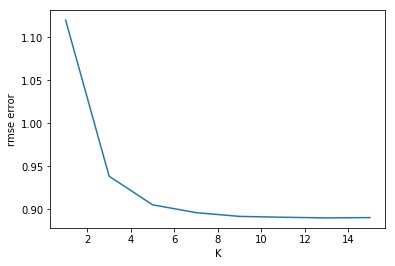

In [499]:
import matplotlib.pyplot as plt
%matplotlib inline

error = []
x = []
for K in range(1, 16, 2):
    test_score = averageScore(train,Recommendation,Weight,K)
    print(f"K:{K}, rmse is {test_score}.")
    error.append(test_score)
    x.append(K)
plt.plot(x, error)
plt.xlabel('K')
plt.ylabel('rmse error')
plt.show()